## Background

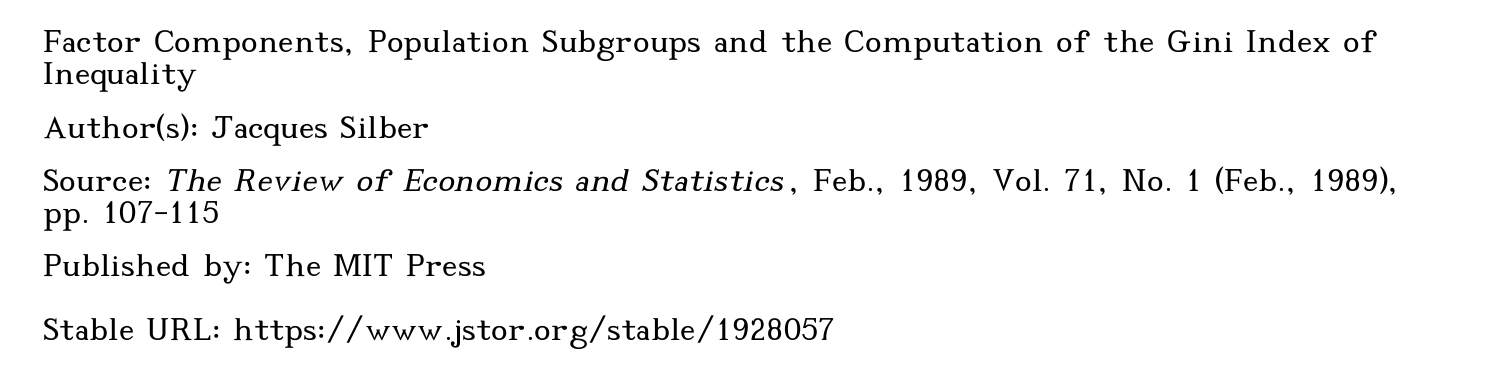

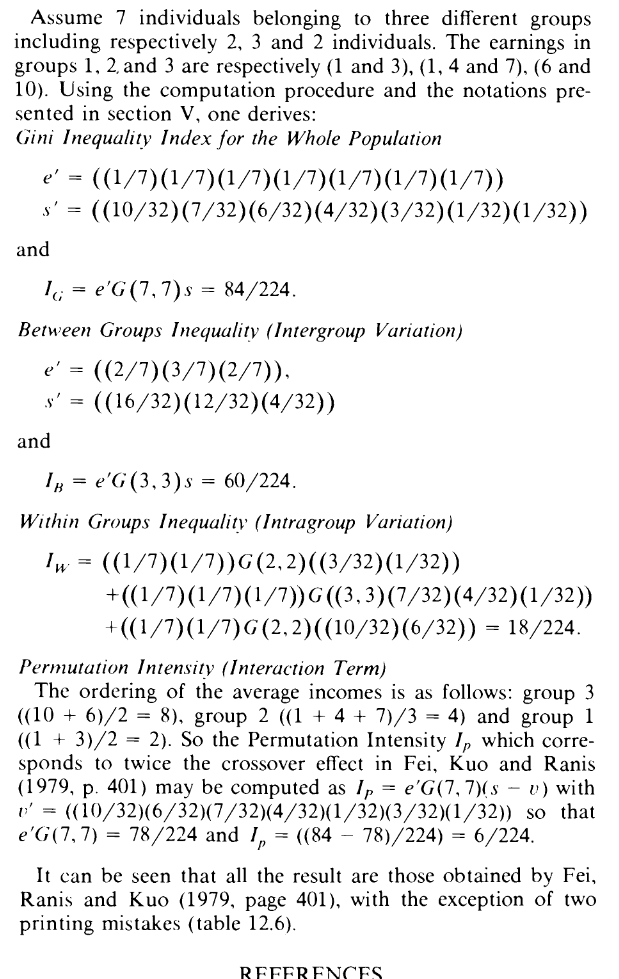

In [7]:
import pandas as pd
import numpy as np

In [8]:
df = pd.DataFrame(data={'y': [1, 3, 1, 4, 7, 6, 10],
                        'group':[1, 1, 2, 2, 2, 3, 3]})

In [9]:
df

,y,group
0,1,1
1,3,1
2,1,2
3,4,2
4,7,2
5,6,3
6,10,3


In [10]:
n = df.shape[0]

In [11]:
D = np.zeros((n,n))

In [14]:
D[np.tril_indices(n, k=-1)] = 1


## Gini

In [16]:
G = D - D.T
GInequality

array([[ 0., -1., -1., -1., -1., -1., -1.],
       [ 1.,  0., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  0., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  0., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  0., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  0., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  0.]])

In [17]:
e = np.array([1/n]*n)
e

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [19]:
df['s'] = df.y / df.y.sum()
df.head(7)

,y,group,s
0,1,1,0.03125
1,3,1,0.09375
2,1,2,0.03125
3,4,2,0.12500
4,7,2,0.21875
5,6,3,0.18750
6,10,3,0.31250


In [22]:
dfs = df.sort_values(by='s', ascending=False)
IG = np.dot(e.T, np.dot(G, dfs.s))

In [23]:
IG

0.375

In [24]:
88/224

0.39285714285714285

In [25]:
dfs.head(7)

,y,group,s
6,10,3,0.31250
4,7,2,0.21875
5,6,3,0.18750
3,4,2,0.12500
1,3,1,0.09375
0,1,1,0.03125
2,1,2,0.03125


In [26]:
10/32

0.3125

## Between Group Inequality

In [36]:
dfb = df.groupby(by='group').sum()

In [37]:
dfb.head()

,y,s
group,,
1,4,0.125
2,12,0.375
3,16,0.500


In [33]:
df.groupby(by='group').count()

,y,s
group,,
1,2,2
2,3,3
3,2,2


In [41]:
dfb['count'] = df.groupby(by='group').count().y

In [42]:
dfb.head()

,y,s,count
group,,,
1,4,0.125,2
2,12,0.375,3
3,16,0.500,2


In [43]:
dfb = dfb.sort_values(by='s', ascending=False)

In [44]:
dfb

,y,s,count
group,,,
3,16,0.500,2
2,12,0.375,3
1,4,0.125,2


In [46]:
e = dfb['count']/dfb['count'].sum()

In [47]:
e

group
3    0.285714
2    0.428571
1    0.285714
Name: count, dtype: float64

In [48]:
IB = np.dot(e.T, np.dot(G[0:3, 0:3], dfb.s))

In [49]:
IB

0.26785714285714285

In [50]:
60/224

0.26785714285714285

## Within Group Inequality 

In [52]:
df

,y,group,s
0,1,1,0.03125
1,3,1,0.09375
2,1,2,0.03125
3,4,2,0.12500
4,7,2,0.21875
5,6,3,0.18750
6,10,3,0.31250


In [53]:
df['e'] = 1

In [74]:
IW = 0
components = []
n = df.shape[0]
for group in df.group.unique():
    print(group)
    dfg = df[df.group==group]
    dfg = dfg.sort_values(by='y', ascending=False)
    eg = dfg.e / n
    ng = eg.shape[0]
    Gg = G[:ng, :ng]
    sg = dfg.y / df.y.sum()
    Iwg = np.dot(eg.T, np.dot(Gg, sg))
    components.append(Iwg)
    IW += Iwg
    

1
2
3


In [75]:
components

[0.008928571428571428, 0.053571428571428575, 0.017857142857142853]

In [76]:
IW

0.08035714285714285

In [78]:
18/224

0.08035714285714286

In [79]:
IG, IB, IW

(0.375, 0.26785714285714285, 0.08035714285714285)

## Interaction Term as Residual

In [86]:
IG - IB - IW

0.0267857142857143

In [87]:
6/224

0.026785714285714284

In [88]:
IP = IG - IB - IW

The residual matches the interaction term.

In [89]:
IP = IG - IB - IW

In [90]:
# Reported
84/224, 60/224, 18/224, 6/224

(0.375, 0.26785714285714285, 0.08035714285714286, 0.026785714285714284)

In [91]:
# Calculated
IG, IB, IW, IP

(0.375, 0.26785714285714285, 0.08035714285714285, 0.0267857142857143)

## TODO

- [X] put into a class
- [ ] add permutation inference
- [ ] document
- [ ] test
- [ ] add to inequality module


### Putting into a class

In [117]:
class Silber:
    def __init__(self, df, y='y', group='group'):
        n = df.shape[0]
        D = np.zeros((n,n))
        D[np.tril_indices(n, k=-1)] = 1
        G = D - D.T
        e = np.array([1/n]*n)
        s = df[y] / df[y].sum()
        dfs = df.copy()
        dfs['s'] = s
        dfs = dfs.sort_values(by='s', ascending=False)
        self.IG = np.dot(e.T, np.dot(G, dfs.s))
        
        # Between Group
        dfb = df.groupby(by=group).sum()
        dfb = dfb.sort_values(by='s', ascending=False)
        dfb['count'] = df.groupby(by=group).count()[y]
        eg = dfb['count']/dfb['count'].sum()
        n_g = len(eg)
        self.IB = np.dot(eg.T, np.dot(G[:n_g, :n_g], dfb.s))

        # Within Group
        IW = 0
        components = []
        for g in df[group].unique():
            dfg = df[df[group]==g]
            dfg = dfg.sort_values(by=y, ascending=False)
            eg = dfg.e / n
            ng = eg.shape[0]
            Gg = G[:ng, :ng]
            sg = dfg.y / df.y.sum()
            Iwg = np.dot(eg.T, np.dot(Gg, sg))
            components.append(Iwg)
            IW += Iwg
        self.IW = IW

        self.IP = self.IG - self.IB - self.IW


    

In [118]:
s = Silber(df)

In [119]:
s.IG, s.IB, s.IW, s.IP

(0.375, 0.26785714285714285, 0.08035714285714285, 0.0267857142857143)